# Influenza A Bulk RNA-seq Data

There is a tutorial for the CRISGITime package using the GSE30550 dataset, which contains bulk RNA-seq data from patients infected with the H3N2 influenza virus. The dataset includes samples collected at different time points and clinical symptoms.

## Installation

```bash
pip install git+https://github.com/compbioclub/CRISGI.git@main
```

## Importing Required Libraries

In [1]:
from crisgi import CRISGITime
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

## Loading Data & Preprocessing

First, we need to load the raw data and preprocess it.

The basic information like the number of samples, genes, and time points can be obtained from the raw data.

The meta_data contains the sample information, including the time points and detailed clinical symptoms.

In [ ]:
# Load raw data and meta data
adata = ad.read_h5ad("./data/GSE30550_raw.adata")
meta_data = pd.read_csv("./data/GSE30550_meta.csv", index_col=0)

# There is a default background network in the raw data, which is not needed for the analysis
del adata.varm["bg_net"]

# Preprocess the data
adata.layers["log1p"] = adata.X
adata.obs["symptom"] = adata.obs["clinic_pheno:ch1"]
adata.obs["subject"] = adata.obs["person"]
# The baseline time point samples are regarded as the reference samples
adata.obs["type"] = adata.obs["time"].apply(
    lambda x: "Ref" if x == "Baseline" else "Test"
)
adata.obs["timepoint"] = adata.obs.time
# Extract the time number from the timepoint column
adata.obs["time"] = adata.obs.timepoint.apply(
    lambda x: -24 if x == "Baseline" else x.replace("Hour ", " ")
).astype(int)
# Combine the subject and time columns to create a unique identifier for each sample
adata.obs["test"] = (
    adata.obs["subject"].astype(str) + " " + adata.obs["time"].astype(str)
)
adata.obs["clinical_symptoms"] = meta_data.loc[
    adata.obs.index, "clinical_symptoms"
].values

# Remove the original columns that are no longer needed
del adata.obs["clinic_pheno:ch1"]

We can save the processed data in a hdf5 file for later use.

In [3]:
adata.write_h5ad("./data/GSE30550_H3N2.h5ad")

Or load the preprocessed data from the hdf5 file.

In [2]:
adata = ad.read_h5ad("./data/GSE30550_H3N2.h5ad")

## Creating CRISGITIME Object

Next, we can create a CRISGITIME object using the preprocessed data. This object will be used for further analysis.

In [3]:
# Define the calculating interaction methods (list format)
interaction_methods = ["pos_coexp"]
# Create CRISGITime object
crisgi_obj = CRISGITime(
    adata=adata,
    interaction_methods=interaction_methods,
    n_hvg=5000,
    organism="human",
    n_threads=1,
    dataset="GSE30550_H3N2",
    class_type="time",
    out_dir="./out",
)

input gene 5000
load bg_net by looping bg_net.
output interactions after bg_net 15753
The number of edge for bg_net is 15753.
Model type set to 'cnn'.


## Reference and Test Populations

We filter the samples to create reference and test populations.

The baseline samples are used as the reference population `ref_obs`, while the test population `test_obss` consists of samples from different time points (all samples).

In [4]:
ref_obs = adata.obs[adata.obs.type == "Ref"].index.to_list()
test_obss = [[x] for x in adata.obs.index.to_list()]

## Calculating Entropy

Parameter `groupby` is used to specify the grouping of the test samples.

In `crisgi_obj.adata.obs`, we can find the `symptom` column, which contains the label (`Symptomatic`/`Asymptomatic`) for each sample.

Filling the proper parameters in `crisgi_obj.calculate_entropy()`, we can calculate the entropy for the test population.

In [5]:
# Set the groupby column
groupby = "symptom"

# Calculate the entropy
crisgi_obj.calculate_entropy(
    ref_obs=ref_obs,
    test_obss=test_obss,
    groupby=groupby,
    ref_time="Ref",
    layer="log1p",
)

reference observations 16
test population 268
Init edata with obs 268 and interaction 15753
---Calculating the entropy for reference group
---Calculating the entropy for test population 0, observations 1
---Calculating the entropy for test population 1, observations 1
---Calculating the entropy for test population 2, observations 1
---Calculating the entropy for test population 3, observations 1
...
---Calculating the entropy for test population 265, observations 1
---Calculating the entropy for test population 266, observations 1
---Calculating the entropy for test population 267, observations 1


## Setting DER/TER Parameters

Here we set the parameters for the DER/TER analysis.

`n_top_interactions` is the number of top interactions to be considered. If set to `None`, all interactions will be considered.

`test_type` is used to specify the type of test to be performed. The options are `DER` (differentially expressed interactions) and `TER` (trend-expressed interactions). `DER` and `TER` are two types of interactions that can be adopted in finding key interactions in the CRISGITime package. `TER` is a subset of `DER`, and it is used to find the interactions that are differentially expressed in a specific trend (up or down) across time points.

`target_group` is used to specify the target group for the analysis, which should be an element in the `groupby` column. In this case, we are interested in the `Symptomatic` group, which contains samples from patients with symptoms.

In [6]:
n_top_interactions = 100
test_type = "TER"
target_group = "Symptomatic"

## Calulating DER and TER

There are three steps to calculate DER and TER. First, we use `test_DER` to calculate DER score for every interaction. Then, we use `get_DER` with specific parameters to get the DER results. Finally, based on the DER results, we use `test_TER` to get the TER results.

The results of DER and TER will be saved in the `crisgi_obj` object and output as CSV files.

In [7]:
crisgi_obj.test_DER(
    groupby="symptom",
    target_group=target_group,
)
crisgi_obj.get_DER(
    target_group=target_group,
    n_top_interactions=n_top_interactions,
    p_adjust=True,
    p_cutoff=0.05,
    fc_cutoff=1,
    sortby="pvals_adj",
)
crisgi_obj.test_TER(target_group=target_group)

[Output] The differential expressed interaction (DER) 100 statistics are saved to:
./out/pos_coexp_symptom_Symptomatic_DER.csv
pos_coexp_symptom_Symptomatic DER 100 TER 99
[Output] The trend expressed interaction (TER) statistics are saved to:
./out/pos_coexp_symptom_Symptomatic_TER.csv


## DER/TER Results Output

Here we can use `pl.interaction_score_line` to get a general overview of the DER/TER results for the `target_group`. This function will plot the average interaction scores for the `target_group` and `ref_group`, allowing us to visualize the differences between the symptomatic and asymptomatic groups.

The `pl.get_interaction_score` and `pl.generate_interaction_score_images` functions can generate every sample's DER/TER result, and it will be output as a CSV file and a heatmap.

The `method` parameter should be an element in the `interaction_methods` list.

pos_coexp_symptom_Symptomatic_TER
None


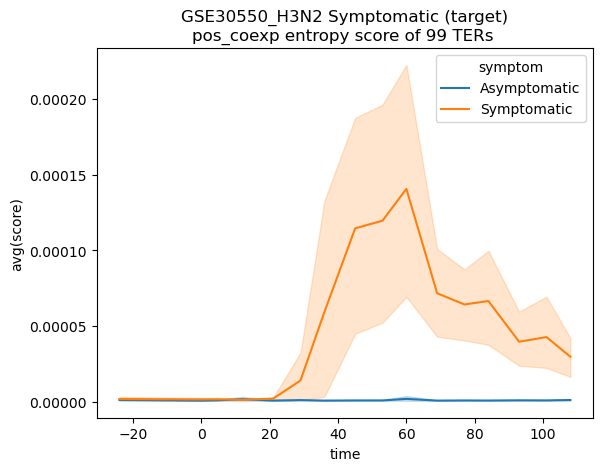

subjects 17 times 16
[Output] The subject 1 pos_coexp symptom Symptomatic TER99 entropy scores are saved to:
./out/1_pos_coexp_symptom_Symptomatic_TER99_interaction_score.csv
[Output] The subject 2 pos_coexp symptom Symptomatic TER99 entropy scores are saved to:
./out/2_pos_coexp_symptom_Symptomatic_TER99_interaction_score.csv
[Output] The subject 3 pos_coexp symptom Symptomatic TER99 entropy scores are saved to:
./out/3_pos_coexp_symptom_Symptomatic_TER99_interaction_score.csv
...
[Output] The subject 16 pos_coexp symptom Symptomatic TER99 entropy scores are saved to:
./out/16_pos_coexp_symptom_Symptomatic_TER99_interaction_score.csv
[Output] The subject 17 pos_coexp symptom Symptomatic TER99 entropy scores are saved to:
./out/17_pos_coexp_symptom_Symptomatic_TER99_interaction_score.csv
[Output] The interaction score image is saved to:
./out\10_pos_coexp_symptom_Symptomatic_TER99_interaction_score_rep0.png
[Output] The interaction score image is saved to:
./out\11_pos_coexp_symptom_Sy

In [12]:
# Import required libraries
import crisgi.plotting_crisgi_time as pl

interaction_method = "pos_coexp"
# Plot general DER/TER results
pl.interaction_score_line(
    crisgi_obj,
    target_group=target_group,
    method=interaction_method,
    test_type=test_type,
    unit_header=None,
)

# Generate interaction score matrix for each subject
pl.get_interaction_score(
    crisgi_obj,
    target_group=target_group,
    groupby=groupby,
    method=interaction_method,
    test_type=test_type,
    subject_header="subject",
    out_dir=None,
)

# Generate interaction score images
pl.generate_interaction_score_images(
    folder_path=crisgi_obj.out_dir,
    output_path=crisgi_obj.out_dir,
    rep_n=1,
    robust=True,
    scale=False,
)

## Startpoint Detection

The `startpoint_detection` function is used to detect the start points (early-warning signals) in the time series data. The results will be saved in the `crisgi_obj.edata.obs.CT_time`.

In [10]:
crisgi_obj.detect_startpoint(symptom_types = ["Symptomatic"])
print(crisgi_obj.edata.obs.CT_time)

test
1 -24     21.0
1 0       21.0
1 5       21.0
1 12      21.0
1 21      21.0
...
17 77      NaN
17 84      NaN
17 93      NaN
17 101     NaN
17 108     NaN
Name: CT_time, Length: 268, dtype: float64


## Training and Predicting with CRISGITime

We can use the `train` & `predict` functions to train and predict the CRISGITime model by using the TER/DER results as the feature matrix.

The `train` function will train the model using the training data, and the `predict` function will use the trained/loaded model to predict the test data.

In [ ]:
# Import required libraries
import torch
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from crisgi.util import ImageDataset
import crisgi.plotting_crisgi_time as pl

# Check if GPU is available and set device
crisgi_obj.device = "cuda" if torch.cuda.is_available() else "cpu"

# Transform for image preprocessing
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_dir = os.path.join(crisgi_obj.out_dir, "images")
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
# Generate interaction score images
pl.plot_interaction_score(
    crisgi_obj,
    output_path=image_dir,
    robust=True,
    scale=False,
    rep_n=2,
    label=True,
)
# Create a dataset and dataloader
dataset = ImageDataset(
    image_dir=image_dir,
    label_csv=os.path.join(image_dir, "labels.csv"),
    transform=transform,
    return_label=True,
)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

[Output] Labels saved to: ./out\images\labels.csv


### Choosing/Loading the Model

There are three different models that can be used in `set_model_type`: `cnn` (3L-CNN), `simple_cnn` (1L-CNN), and `logistic` (logistic regression).

The `model_type` parameter is used to specify the model type. You can load the model from a file in `ae_path` and `mlp_path` if you want to use a pre-trained model, or train a new model with `None`.

In [ ]:
# 3L-CNN model
crisgi_obj.set_model_type(
    model_type="cnn",
    # ae_path="./data/model/3L-CNN/GSE30550_H3N2_ae_model.pth",
    # mlp_path="./data/model/3L-CNN/GSE30550_H3N2_mlp_model.pth",
    device=crisgi_obj.device,
)

Model type set to 'cnn'.


In [26]:
# 1L-CNN model
crisgi_obj.set_model_type(
    model_type="simple_cnn",
    # ae_path="./data/model/1L-CNN/GSE30550_H3N2_ae_single_model.pth",
    # mlp_path="./data/model/1L-CNN/GSE30550_H3N2_mlp_single_model.pth",
    device=crisgi_obj.device,
)

Model type set to 'simple_cnn'.


In [ ]:
# Logistic regression model
crisgi_obj.set_model_type(model_type='logistic',
    # model_path="./data/model/logistic/GSE30550_H3N2_log_model.pth",
    device = crisgi_obj.device,
)

Model type set to 'logistic'.


### Training the Model

In [27]:
crisgi_obj.train(train_loader=loader, epochs=20)


Epoch 1/20
Total Train Loss: 3.9969566043685463
Train Accuracy: 47.05882352941177%

Epoch 2/20
Total Train Loss: 0.5858943539068979
Train Accuracy: 64.70588235294117%

Epoch 3/20
Total Train Loss: 0.11467249735313303
Train Accuracy: 82.3529411764706%
...
Epoch 19/20
Total Train Loss: 0.010214821873780559
Train Accuracy: 97.05882352941177%

Epoch 20/20
Total Train Loss: 0.0028154985869632046
Train Accuracy: 100.0%


{'AUROC': 1.0,
 'AUPRC': 1.0,
 'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'Sensitivity': 1.0,
 'Specificity': 1.0,
 'PPV': 1.0,
 'NPV': 1.0,
 'F1_Score': 1.0,
 'Kappa': 1.0,
 'Brier_Score': 0.0}

### Predicting the Model

In [28]:
predictions = crisgi_obj.predict(loader)
print(predictions)

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]


### Saving the Model

In [ ]:
torch.save(crisgi_obj.model.ae, "./data/GSE30550_H3N2_ae_model.pth") 
torch.save(crisgi_obj.model.mlp, "./data/GSE30550_H3N2_mlp_model.pth")

## Enrichment Analysis

We have four different levels of enrichment analysis for you to choose: `cohort_level_top_n_ORA`, `Phenotype-level Accumulated Top n ORA`, `Phenotype-level CT-rank enrichment`, and `Observation-level CT-rank enrichment`.

### Cohort-level Top n ORA

To capture CT interactions that are consistently strong across a cohort, we sum up the CRISGI scores for each interaction across all observations. The top-*n* interactions from this aggregate ranking were then used for over-representation analysis (ORA), identifying pathways enriched among globally dominant CT interactions across the population.

In [21]:
# The result will be generated in ./{out_dir}/{interaction_method}_cohort_enrich.csv
crisgi_obj.cohort_level_top_n_ORA(
    n_top_interactions=30,
    n_space=10,
    method="pos_coexp",
    gene_sets=[
        "KEGG_2021_Human",
        "GO_Molecular_Function_2023",
        "GO_Cellular_Component_2023",
        "GO_Biological_Process_2023",
        "MSigDB_Hallmark_2020",
    ],
    background=None,
    organism="human",
    plot=True,
)

_enrich_for_top_n 10
_enrich_for_top_n 20
_enrich_for_top_n 30
[Output] The pos_coexp cohort-level enrich statistics are saved to:
./out/pos_coexp_cohort_enrich.csv


In [23]:
# Also, the results can be accessed through the edata object
crisgi_obj.edata.uns[f"{interaction_method}_cohort_enrich_df"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_gene,top_n,top_n_ratio
0,KEGG_2021_Human,Vitamin digestion and absorption,2/24,0.000090,0.001447,0,0,181.509091,1690.049095,APOA1;APOB,2,10,0.200000
1,KEGG_2021_Human,Fat digestion and absorption,2/43,0.000294,0.002122,0,0,97.302439,791.273330,APOA1;APOB,2,10,0.200000
2,KEGG_2021_Human,Cholesterol metabolism,2/50,0.000398,0.002122,0,0,83.083333,650.497584,APOA1;APOB,2,10,0.200000
3,KEGG_2021_Human,Complement and coagulation cascades,2/85,0.001146,0.004584,0,0,47.963855,324.786952,A2M;CLU,2,10,0.200000
4,KEGG_2021_Human,Lipid and atherosclerosis,2/215,0.007072,0.022629,0,0,18.568075,91.942655,APOA1;APOB,2,10,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MSigDB_Hallmark_2020,Inflammatory Response,1/200,0.303808,0.303808,0,0,2.837760,3.380791,IL1B,1,30,0.033333
1040,MSigDB_Hallmark_2020,Xenobiotic Metabolism,1/200,0.303808,0.303808,0,0,2.837760,3.380791,CNDP2,1,30,0.033333
1041,MSigDB_Hallmark_2020,Oxidative Phosphorylation,1/200,0.303808,0.303808,0,0,2.837760,3.380791,ALDH6A1,1,30,0.033333
1042,MSigDB_Hallmark_2020,heme Metabolism,1/200,0.303808,0.303808,0,0,2.837760,3.380791,ALDH6A1,1,30,0.033333


### Phenotype-level Accumulated Top n ORA

We can perform ORA on incremental top-*n* CT interactions, ranked by CRISGI z-scores from differential testing, using a predefined step size. For each significantly enriched pathway, we can compute a normalized Top Ratio (`nTopRatio`), defined as the fraction of pathway-associated CT interactions within each top-*n* subset. 

Pathways are ranked by cumulative `nTopRatio` across all increments to highlight consistently enriched pathways across high-ranking CTs. 

_enrich_for_top_n 10
_enrich_for_top_n 20
_enrich_for_top_n 30
[Output] The pos_coexp symptom Symptomatic TER enrich statistics are saved to:
./out/pos_coexp_symptom_Symptomatic_TER_enrich.csv
[Output] The pos_coexp symptom Symptomatic TER GO_Biological_Process_2023 top_n_ratio top_n enrichment is saved to:
./out/pos_coexp_symptom_Symptomatic_TER_GO_Biological_Process_2023_top_n_ratio_enrich_top_n.png


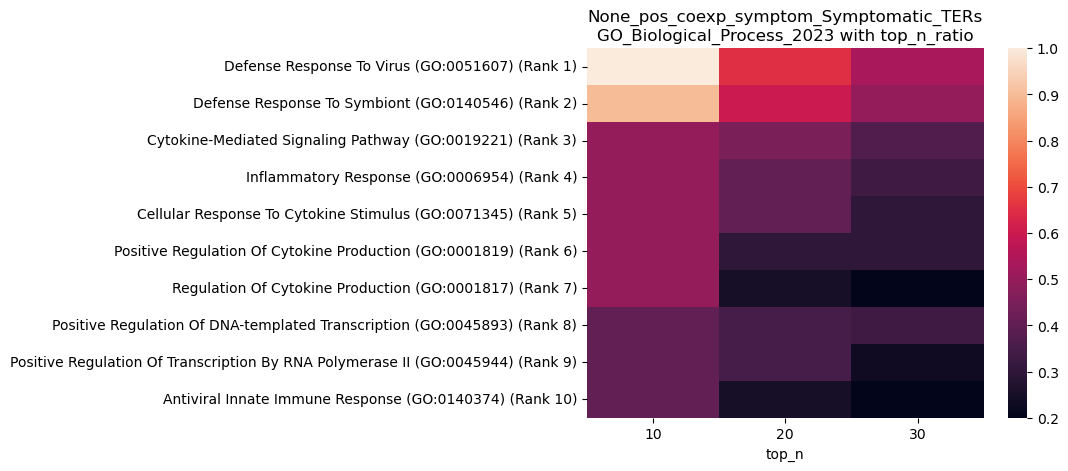

[Output] The pos_coexp symptom Symptomatic TER GO_Molecular_Function_2023 top_n_ratio top_n enrichment is saved to:
./out/pos_coexp_symptom_Symptomatic_TER_GO_Molecular_Function_2023_top_n_ratio_enrich_top_n.png


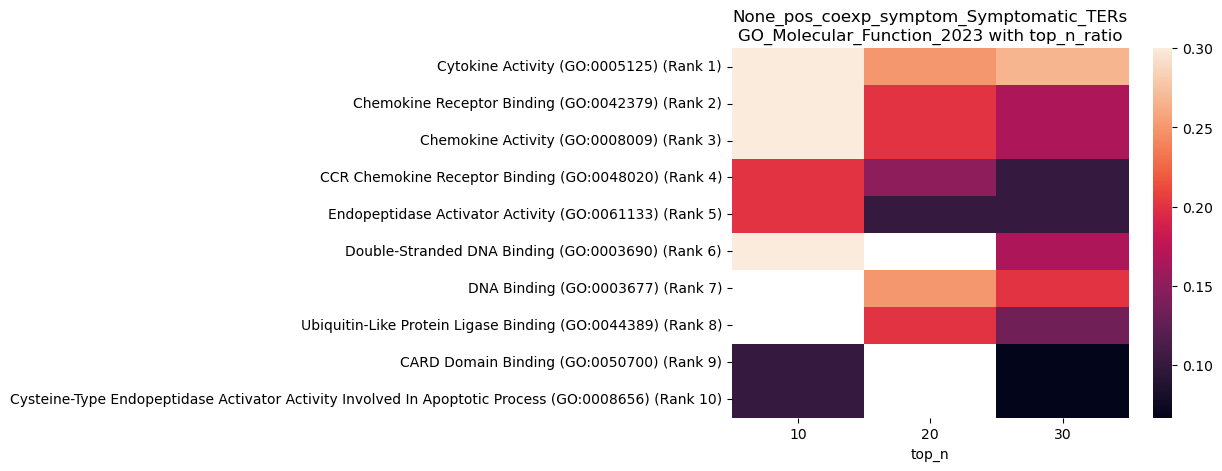

[Output] The pos_coexp symptom Symptomatic TER KEGG_2021_Human top_n_ratio top_n enrichment is saved to:
./out/pos_coexp_symptom_Symptomatic_TER_KEGG_2021_Human_top_n_ratio_enrich_top_n.png


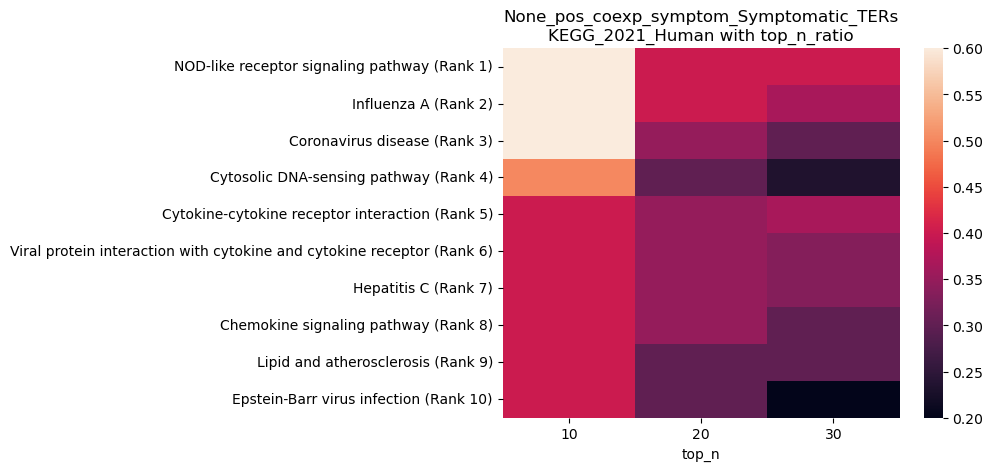

[Output] The pos_coexp symptom Symptomatic TER MSigDB_Hallmark_2020 top_n_ratio top_n enrichment is saved to:
./out/pos_coexp_symptom_Symptomatic_TER_MSigDB_Hallmark_2020_top_n_ratio_enrich_top_n.png


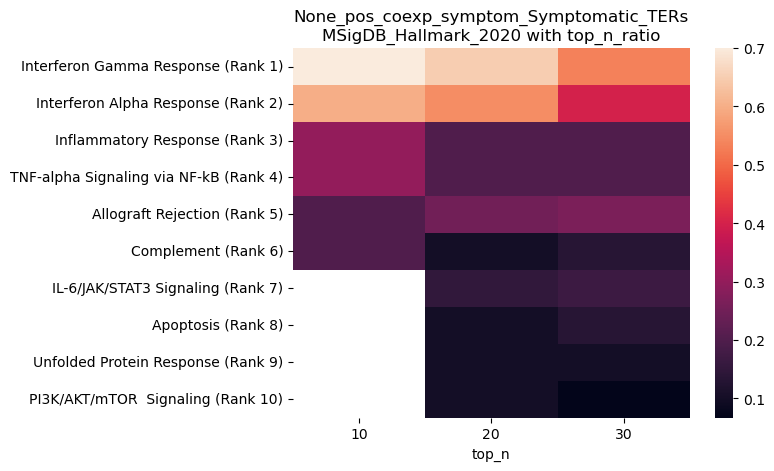

In [12]:
crisgi_obj.n_threads = 1
interaction_method = "pos_coexp"

# The result will be generated in {interaction_method}_{groupby}_{target_group}_{test_type}_enrich.csv in out_dir
crisgi_obj.pheno_level_accumulated_top_n_ORA(
    target_group=target_group,
    n_top_interactions=30,
    n_space=10,
    method=interaction_method,
    test_type=test_type,
)

# Plot the phenotype-level accumulated top n ORA results
pl.pheno_level_accumulated_top_n_ORA(
    crisgi_obj,
    target_group=target_group,
    p_adjust=True,
    p_cutoff=0.05,
    n_top_interactions=30,
    method=interaction_method,
    test_type=test_type,
)

In [13]:
# Also, the results can be accessed through the edata object
crisgi_obj.edata.uns[f"{interaction_method}_{groupby}_{target_group}_{test_type}_enrich_df"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_gene,top_n,top_n_ratio
0,KEGG_2021_Human,Cytosolic DNA-sensing pathway,5/63,5.164674e-10,2.001242e-08,0,0,190.881226,4081.805842,CXCL10;AIM2;TBK1;IRF7;CASP1,5,10,0.500000
1,KEGG_2021_Human,Influenza A,6/172,1.051221e-09,2.001242e-08,0,0,89.548193,1851.257888,CXCL10;TBK1;MX1;IRF7;CASP1;CCL2,6,10,0.600000
2,KEGG_2021_Human,NOD-like receptor signaling pathway,6/181,1.429458e-09,2.001242e-08,0,0,84.904286,1729.158160,AIM2;TBK1;IFI16;IRF7;CASP1;CCL2,6,10,0.600000
3,KEGG_2021_Human,Coronavirus disease,6/232,6.345181e-09,6.662440e-08,0,0,65.575221,1237.769693,CXCL10;TBK1;MX1;CASP1;CCL2;ISG15,6,10,0.600000
4,KEGG_2021_Human,RIG-I-like receptor signaling pathway,4/70,1.341046e-07,1.126479e-06,0,0,120.727273,1910.466285,CXCL10;TBK1;IRF7;ISG15,4,10,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,MSigDB_Hallmark_2020,Fatty Acid Metabolism,1/158,2.365362e-01,2.896478e-01,0,0,3.823393,5.512010,UBE2L6,1,30,0.033333
972,MSigDB_Hallmark_2020,heme Metabolism,1/200,2.896478e-01,2.896478e-01,0,0,3.010050,3.729722,ACKR1,1,30,0.033333
973,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,2.896478e-01,2.896478e-01,0,0,3.010050,3.729722,TBK1,1,30,0.033333
974,MSigDB_Hallmark_2020,E2F Targets,1/200,2.896478e-01,2.896478e-01,0,0,3.010050,3.729722,TP53,1,30,0.033333


### Phenotype-level CT-rank enrichment

Using Kolmogorov-Smirnov (KS)-like statistic, we can compute enrichment scores over the full ranking of CT genes based on their phenotype-specific CRISGI z-scores derived from differential test (phenotype A vs. phenotype B). This reveals pathways with directional fluctuation or stability trends across the ranked list.

Positive enrichment scores indicate pathway in phenotype A exhibits elevated fluctuations (i.e., more prominent CT signals); negative scores imply relative stability compared to phenotype B.

In [14]:
# Set the reference and target groups for the CT rank test
ref_group = "Asymptomatic"
target_group = "Symptomatic"
# Results will be saved in the folder ./out_dir/{prefix}_{ref_group}_{target_group}
crisgi_obj.pheno_level_CT_rank(
    ref_group=ref_group,
    target_group=target_group,
    n_top_interactions=n_top_interactions,
    sortby="pvals_adj",
    gene_sets=[
        "KEGG_2021_Human",
        "GO_Molecular_Function_2023",
        "GO_Cellular_Component_2023",
        "GO_Biological_Process_2023",
        "MSigDB_Hallmark_2020",
    ],
    prefix="pheno_level_CT_rank",
    min_size=5,
    max_size=1000,
    permutation_num=1000,
    seed=0,
)

2025-05-06 03:45:44,853 [WARNING] Duplicated values found in preranked stats: 84.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-05-06 03:45:44,854 [INFO] Parsing data files for GSEA.............................
2025-05-06 03:45:44,855 [INFO] Enrichr library gene sets already downloaded in: C:\Users\LVCS\.cache/gseapy, use local file
2025-05-06 03:45:44,859 [INFO] Enrichr library gene sets already downloaded in: C:\Users\LVCS\.cache/gseapy, use local file
2025-05-06 03:45:44,865 [INFO] Enrichr library gene sets already downloaded in: C:\Users\LVCS\.cache/gseapy, use local file
2025-05-06 03:45:44,871 [INFO] Enrichr library gene sets already downloaded in: C:\Users\LVCS\.cache/gseapy, use local file
2025-05-06 03:45:44,894 [INFO] Enrichr library gene sets already downloaded in: C:\Users\LVCS\.cache/gseapy, use local file
2025-05-06 03:45:44,918 [INFO] 7154 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-05-06 03

In [15]:
# The results can be accessed through the gp_res object
crisgi_obj.gp_res.results

{'KEGG_2021_Human__Platelet activation': {'name': 'prerank',
  'es': -0.28823529411764703,
  'nes': -0.8502622255406148,
  'pval': 0.6423357664233577,
  'fdr': 1.0,
  'fwerp': 1.0,
  'tag %': '6/6',
  'gene %': '72.73%',
  'lead_genes': 'COL1A2;GNAI2;AKT2;GNAQ;PIK3R1;F2',
  'matched_genes': 'F2;PIK3R1;GNAQ;AKT2;GNAI2;COL1A2',
  'hits': [49, 61, 70, 115, 155, 169],
  'RES': [-0.0058823529411764705,
   -0.011764705882352941,
   -0.01764705882352941,
   -0.023529411764705882,
   -0.029411764705882353,
   -0.017543859649122806,


### Observation-level CT-rank enrichment

We extend the KS-like enrichment analysis to the observation level using CRISGI scores specific to each observation.

A positive enrichment score reflects pathway actively fluctuating in that observation, while a negative score indicates stability.

In [16]:
# Parameters for the observation-level CT rank test
enrich_dataset = "GSE30550_H3N2"
interaction_method = "pos_coexp"

# Set the 
interactions = crisgi_obj.edata.uns[
    f"{interaction_method}_{groupby}_{target_group}_{test_type}"
][0:n_top_interactions]
gene_sets = {f"{enrich_dataset} {test_type}{n_top_interactions}": interactions}

# The results will be generated in ./out_dir/{prefix} folder
crisgi_obj.obs_level_CT_rank(
    gene_sets=gene_sets,
    prefix="obs_level_CT_rank",
    min_size=5,
)

In [17]:
# The results can be accessed through the gp_es object
crisgi_obj.gp_es.results

{'1 -24': {'GSE30550_H3N2 TER100': {'name': '1 -24',
   'es': -0.3363774857096424,
   'nes': 0.0,
   'pval': 0.0,
   'fdr': 0.0,
   'fwerp': 0.0,
   'tag %': '',
   'gene %': '',
   'lead_genes': '',
   'matched_genes': '',
   'hits': [],
   'RES': []}},
 '1 0': {'GSE30550_H3N2 TER100': {'name': '1 0',
